<a href="https://colab.research.google.com/github/RemiArbache/NLP-Project/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis 


Sommaire disponible ici :

 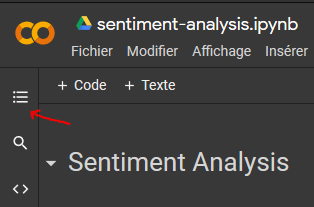

<a name="0"></a>
## Imports du projet et des librairies 

Veuillez importer les fichiers du projet via le lien ci-dessous : 

https://drive.google.com/drive/folders/18Qkedfia8GFN4-GgpXKFN5-w6swJHgkb?usp=sharing

In [274]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from time import time
import numpy as np
import pandas as pd
import tensorflow as tf

# Import Regex to clean up tweets
import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Get Reviews
import requests
import json

# Get Tweets
import httplib2
import requests
import urllib3
from drive.MyDrive.Twitter_Dataset.random_tweets import *

# TF IDF Imports


from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split  
from scipy.sparse import csc_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

# RNN & LSTM Imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random




Mounted at /content/drive


In [275]:
DF = pd.read_csv('/content/drive/MyDrive/Twitter_Dataset/tweets.csv',encoding='latin',usecols=[0, 5], # to take only 2 useful columns
                 names=["label","tweet"])

In [276]:
DF['label'].replace([4, 0],[1, 0], inplace=True) # Replace 0 and 4 by 0 and 1 to clarify

In [277]:
  print(DF.head(25))
  len(DF)

    label                                              tweet
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  is upset that he can't update his Facebook by ...
2       0  @Kenichan I dived many times for the ball. Man...
3       0    my whole body feels itchy and like its on fire 
4       0  @nationwideclass no, it's not behaving at all....
5       0                      @Kwesidei not the whole crew 
6       0                                        Need a hug 
7       0  @LOLTrish hey  long time no see! Yes.. Rains a...
8       0               @Tatiana_K nope they didn't have it 
9       0                          @twittera que me muera ? 
10      0        spring break in plain city... it's snowing 
11      0                         I just re-pierced my ears 
12      0  @caregiving I couldn't bear to watch it.  And ...
13      0  @octolinz16 It it counts, idk why I did either...
14      0  @smarrison i would've been the first, but i di...
15      0  @iamjazzyfizz

1600000

On peut voir que les tweets contiennent des mentions, des urls, etc. qui ne sont pas utiles au modèle de langage. Il faut donc nettoyer leur contenu.

<a name="1"></a>
## Pré-Traitement



<a name="1.1"></a>
### Nettoyage et Tokenization
J'utilise la fonction clean trouvée sur Kaggle pour nettoyer les tweets.
Les contractions sont séparées, les charactères spéciaux sont supprimés, ainsi que les URLs, les mentions, les mots trops courts, et les stopwords. 

Les tweets sont aussi transformés en Tokens grâce à la librairie ```nltk```.


In [278]:
tokenizer = TweetTokenizer(strip_handles=True)
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
corpus = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [279]:
def clean(tweet): 
            
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)  
    
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"yrs", "years", tweet)
    tweet = re.sub(r"hrs", "hours", tweet)
    tweet = re.sub(r"2morow|2moro", "tomorrow", tweet)
    tweet = re.sub(r"2day", "today", tweet)
    tweet = re.sub(r"4got|4gotten", "forget", tweet)
    tweet = re.sub(r"b-day|bday", "b-day", tweet)
    tweet = re.sub(r"mother's", "mother", tweet)
    tweet = re.sub(r"mom's", "mom", tweet)
    tweet = re.sub(r"dad's", "dad", tweet)
    tweet = re.sub(r"hahah|hahaha|hahahaha", "haha", tweet)
    tweet = re.sub(r"lmao|lolz|rofl", "lol", tweet)
    tweet = re.sub(r"thanx|thnx", "thanks", tweet)
    tweet = re.sub(r"goood", "good", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    # Urls
    tweet = re.sub(r"http\S+", "", tweet)
    # Numbers
    tweet = re.sub(r'[0-9]', '', tweet)
    # Eliminating the mentions
    tweet = re.sub("(@[A-Za-z0-9_]+)","", tweet)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        tweet = tweet.replace(p, '')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')
        
    # Tokenize
    tweet_words = tokenizer.tokenize(tweet)
    
    # Eliminating the word if its length is less than 3
    tweet = [w for w in tweet_words if len(w)>2]
    
    # remove stopwords
    tweet = [w.lower() for w in tweet if not w in stop_words]  
    
    corpus.append(tweet)
    
    # join back
    tweet = ' '.join(tweet)
        
        
    return tweet

Les abbréviations seront remplacées par leur homologue complet grâce à ce dictionnaire d'abbréviations et à la fonction ```convert_abbrev_in_text``` associée

In [280]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(tweet):
    t=[]
    words=tweet.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

La fonction suivante exécute les deux fonctions définies au-dessus sur un tweet donné :

In [281]:
def prepare_string(tweet):
  tweet = clean(tweet)
  tweet = convert_abbrev_in_text(tweet)
  return tweet

Cette étape peut prendre quelques minutes, elle applique la fonction de nettoyage à tous les tweets du corpus de texte et supprime les lignes qui sont vides après le nettoyage.

In [ ]:
%%time
# Apply prepare_string to all rows in 'tweets' column
DF['tweet'] = DF['tweet'].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
DF['tweet'].replace('', np.nan, inplace=True)
DF.dropna(subset=['tweet'], inplace=True)

CPU times: user 4min 59s, sys: 862 ms, total: 5min
Wall time: 5min


In [ ]:
DF.head(25)

,label,tweet
0,0,awww bummer shoulda got david carr third day
1,0,upset cannot update facebook texting might cry...
2,0,dived many times ball managed save rest bounds
3,0,whole body feels itchy like fire
4,0,behaving mad cannot see
...,...,...
203,0,going kill seen waiting till one solid week si...
204,0,think right hahaa hours
205,0,hate see spartans sad
206,0,mind body severely protesting quotgetting upqu...


Le DataFrame obtenu est converti en CSV et téléchargé afin d'éviter la ré-exécution du code précédent qui est gourmande en ressources et en temps.

In [ ]:
DF.to_csv('/content/drive/MyDrive/Twitter_Dataset/cleaned_tweets.csv', index=False)

Les données sont maintenant prêtes à être soumises aux différentes méthodes de traitement.

## Récupération de reviews sur Yelp

In [252]:
#@markdown Renvoie une review de librairie aléatoire

def get_random_review():
  # Your Yelp API key here : 
  api_key = ""
  headers = {'Authorization': 'Bearer %s' % api_key}

  url = 'https://api.yelp.com/v3/businesses/search'
  params = {'term':'bookstore','location':'New York City'}

  req = requests.get(url, params=params, headers=headers)

  parsed = json.loads(req.text)
  
  businesses = parsed["businesses"]
  
  business = random.choice(businesses)

  id = business["id"]

  url="https://api.yelp.com/v3/businesses/" + id + "/reviews"

  req = requests.get(url, headers=headers)

  parsed = json.loads(req.text)

  reviews = parsed["reviews"]

  return random.choice(reviews)["text"]

In [253]:
print(get_random_review())

NYC landmark - bookstore that lived through the World Wars. Of course I rushed there to use $$$ after seeing their social media post that they needed help...


## Récupération de Tweets

In [248]:
#@markdown Renvoie un tweet aléatoire contenant le mot donné

#@markdown Nécessite une clé d'API Twitter : 
API_KEY = "" #@param {type:"string"}
SECRET = "" #@param {type:"string"}
# Your Twitter API credentials here : 
def get_random_tweet(target :string):
  credentials = {
          'consumer_key': str(API_KEY),
          'consumer_secret': str(SECRET)
      }
  return rt_get_random_tweet(target, credentials)['text']

In [249]:
print(get_random_tweet("cat"))

RT @elenafms: ⁦@jfueyomargareto⁩ sabe mucho, merece la pena escucharlo!!... https://t.co/O1iChu9lxs via @CatalunyaRadio https://t.co/KKF08B…


<a name="3"></a>
## TF-IDF
Utilisation de la TF-IDF pour entraîner un modèle capable de prédire le sentiment d'un tweet.


In [218]:
#@title Chargement des données
#@markdown Si le pré-traitement n'a pas été effectué, il est possible de charger les données pré-traitées depuis le Drive (il faut exécuter la cellule pour valider le choix).
load_saved_data = True #@param {type:"boolean"}

#Optionnel : Rechargement des tweets nettoyés à partir du drive 
if load_saved_data:
  from google.colab import drive
  drive.mount('/content/drive/', force_remount=True)
  DF = pd.read_csv('/content/drive/MyDrive/Twitter_Dataset/cleaned_tweets.csv',encoding='latin', names=["label","tweet"], header=None, skiprows=1)


Mounted at /content/drive/


#### Répartition des données de test et d'entraînement

In [197]:
# Utiliser toutes les données excède la capacité de RAM du Notebook 
corpus_size = int(20000)

# Les tweets sont choisis au début et à la fin du jeu de données pour avoir des sentiments positifs et négatifs à parts égales
tweets = [*DF['tweet'].values[:int(corpus_size/2)], *DF['tweet'].values[-int(corpus_size/2):]]
# De même pour les targets assoicées
y = [*DF['label'].values[:int(corpus_size/2)], *DF['label'].values[-int(corpus_size/2):]]

# Le jeu de données est découpé pour entraîner le classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.025, random_state=0)


#### Vectorisation en TF IDF 

In [198]:
# J'utilise la bibliothèque sklearn qui implémente la TF-IDF
tfIdfVectorizer = TfidfVectorizer()
X = tfIdfVectorizer.fit_transform(tweets).toarray()

#### Création et entraînement du modèle de classification

In [138]:
# La classification est une RandomForestClassifier dont le nombre d'estimateurs a été réduit à 15 pour des raisons de RAM
text_classifier = RandomForestClassifier(n_estimators=15, random_state=0)  
text_classifier.fit(X_train, y_train )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [139]:
predictions = text_classifier.predict(X_test)

# Matrice des vrais positifs/négatifs et faux positifs/négatifs
print(confusion_matrix(y_test,predictions)) 
# Résumé de la classification
print(classification_report(y_test,predictions))  
# Précision finale ( 0.724 )
print(accuracy_score(y_test, predictions))

[[163  78]
 [ 53 206]]
              precision    recall  f1-score   support

           0       0.75      0.68      0.71       241
           1       0.73      0.80      0.76       259

    accuracy                           0.74       500
   macro avg       0.74      0.74      0.74       500
weighted avg       0.74      0.74      0.74       500

0.738



On observe que le modèle a un taux correct de précision et évite relativement les faux positifs et les faux négatifs.

---
Le classifier et le vectorizer sont sauvegardés pour réduire le temps de calcul lors de l'utilisation normale.
Le vectorizer contient le vocabulaire appris et le classifier permet d'estimer le sentiment du tweet.


In [142]:
dump(text_classifier, '/content/drive/MyDrive/Twitter_Dataset/RandomForestTextClassifier.joblib')
dump(tfIdfVectorizer, '/content/drive/MyDrive/Twitter_Dataset/tfIdfVectorizer.joblib')

['/content/drive/MyDrive/Twitter_Dataset/tfIdfVectorizer.joblib']

### Pipeline complète d'utilisation de la TF-IDF :

In [250]:
loaded_classifier = load('/content/drive/MyDrive/Twitter_Dataset/RandomForestTextClassifier.joblib')
loaded_vectorizer = load('/content/drive/MyDrive/Twitter_Dataset/tfIdfVectorizer.joblib')

def tf_idf_pipeline_from_tweets(subject :str):
  raw_tweet = get_random_tweet(subject)
  print("Raw Tweet : " + raw_tweet)
  cleaned_tweet = prepare_string(raw_tweet)
  print("Processed Tweet : " + cleaned_tweet)
  word_vector = loaded_vectorizer.transform([cleaned_tweet])

  return bool(loaded_classifier.predict(word_vector.reshape(1,-1))[0])

def tf_idf_pipeline_from_yelp():
  raw_tweet = get_random_review()
  print("Raw Review : " + raw_tweet)
  cleaned_tweet = prepare_string(raw_tweet)
  print("Processed Review : " + cleaned_tweet)
  word_vector = loaded_vectorizer.transform([cleaned_tweet])

  return bool(loaded_classifier.predict(word_vector.reshape(1,-1))[0])



In [251]:
print(tf_idf_pipeline_from_tweets("pizza"))
print(tf_idf_pipeline_from_yelp())

Raw Tweet : hmmmmmmmmmmmmm vou pedi minha pizza com o ✨meu✨ cupom de desconto o ✨MEU✨ tô me achando mto
Processed Tweet : hmmmmmmmmmmmmm vou pedi minha pizza com meu cupom desconto meu achando mto
False
aaaaaaaa
gfggedrf
Raw Review : BOOKS + Beer!!! Came here for a friends book reading. It's a very cool space, but just make sure your group is small.  Also this place is super chill and...
Processed Review : books beer came friends book reading cool space make sure group small also place super chill
True


En faisant quelques essais, on observe que la précision des prédictions est beaucoup plus faible lorsqu'il s'agit d'analyser des reviews. Cela peut être dû au fait que le modèle est entraîné sur des tweets. Cela peut aussi être dû au fait que Yelp ne permet d'obtenir que les 160 premiers caractères d'une review.

<a name="4"></a>
## RNN & LSTM : GLoVe

In [255]:
#@title Chargement des données
#@markdown Si le pré-traitement n'a pas été effectué, il est possible de charger les données pré-traitées depuis le Drive.
load_saved_data = True #@param {type:"boolean"}

#Optionnel : Rechargement des tweets nettoyés à partir du drive:
if load_saved_data:
  from google.colab import drive
  drive.mount('/content/drive/', force_remount=True)
  DF = pd.read_csv('/content/drive/MyDrive/Twitter_Dataset/cleaned_tweets.csv',encoding='latin', names=["label","tweet"], header=None, skiprows=1)


Mounted at /content/drive/


La cellules suivante permet d'adapter la stratégie d'entrînement du modèle au matériel mis à disposition.

In [256]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

Device: grpc://10.9.178.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.9.178.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.9.178.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


In [257]:
# Création de tuples (tweet, label) en prévision du mélange des données
corpus = list(zip(DF['tweet'].values, DF['label'].values))


embedding_dim = 100    # Dimensions utilisées pour glove6b100
max_length = 20        # Taille maximale d'un tweet
trunc_type='post'      # Tronque le tweet s'il est plus long que max_length
padding_type='post'    # Ajoute du padding à la fin du tweet s'il est plus court que max_length
oov_tok = "<OOV>"      # Token "<OOV>" remplace les mots qui ne font pas partie du vocabulaire (Out Of Vocabulary)
training_size=len(corpus)
test_portion=.025


corpus[:5]

[('awww bummer shoulda got david carr third day', 0),
 ('upset cannot update facebook texting might cry result school today also blah',
  0),
 ('dived many times ball managed save rest bounds', 0),
 ('whole body feels itchy like fire', 0),
 ('behaving mad cannot see', 0)]

#### Répartition des données de test et d'entraînement

In [258]:
sentences=[]
labels=[]

# Mélange des données
random.shuffle(corpus)

# Séparation des labels et des tweets
for x in range(training_size):
    sentences.append(str(corpus[x][0]))
    labels.append(corpus[x][1])

# Formation du vocabulaire sur les tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# Création de la map comportant les mots du vocabulaire associés à des indices
word_index = tokenizer.word_index
vocab_size=len(word_index)

# Création de vecteurs one-hot à partir des tweets
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Création des jeux d'entraînement pour le réseau neuronal
split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [270]:
# Save tokenizer for later
dump(tokenizer, '/content/drive/MyDrive/Twitter_Dataset/RNNTokenizer.joblib')

['/content/drive/MyDrive/Twitter_Dataset/RNNTokenizer.joblib']

#### GLoVe : Création de la matrice de poids

In [259]:
embeddings_index = {};


with open('/content/drive/MyDrive/Twitter_Dataset/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

#### Création du réseau neuronal LSTM

In [260]:
with strategy.scope():    
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False), # Couche d'entrée chargée avec les poids de GLoVe
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(units=64, return_sequences=True)),
        tf.keras.layers.Bidirectional(LSTM(units=128)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
       
  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           41561800  
_________________________________________________________________
dropout (Dropout)            (None, 20, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 41,925,961
Trainable params: 364,161
Non-trainable params: 41,561,800
______________________________________

#### Entraînement et sauvegarde du modèle

In [261]:
num_epochs = 10

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

In [262]:
history = model.fit(training_padded, 
                      training_labels, 
                      epochs=num_epochs, 
                      validation_data=(testing_padded, testing_labels),
                      batch_size = 256,
                      verbose=1)
  
print("Training Complete")

Epoch 1/10
6059/6059 [==============================] - 138s 21ms/step - loss: 0.6108 - accuracy: 0.6978 - val_loss: 0.4943 - val_accuracy: 0.7613
Epoch 2/10
6059/6059 [==============================] - 124s 20ms/step - loss: 0.5202 - accuracy: 0.7397 - val_loss: 0.4784 - val_accuracy: 0.7693
Epoch 3/10
6059/6059 [==============================] - 126s 21ms/step - loss: 0.5059 - accuracy: 0.7501 - val_loss: 0.4722 - val_accuracy: 0.7723
Epoch 4/10
6059/6059 [==============================] - 125s 21ms/step - loss: 0.4991 - accuracy: 0.7552 - val_loss: 0.4678 - val_accuracy: 0.7748
Epoch 5/10
6059/6059 [==============================] - 124s 20ms/step - loss: 0.4951 - accuracy: 0.7580 - val_loss: 0.4693 - val_accuracy: 0.7760
Epoch 6/10
6059/6059 [==============================] - 126s 21ms/step - loss: 0.4918 - accuracy: 0.7596 - val_loss: 0.4678 - val_accuracy: 0.7765
Epoch 7/10
6059/6059 [==============================] - 124s 20ms/step - loss: 0.4881 - accuracy: 0.7620 - val_loss: 0

In [264]:
model.save('/content/drive/MyDrive/Twitter_Dataset/model.h5')

#### Affichage de la progression du modèle

<Figure size 432x288 with 0 Axes>

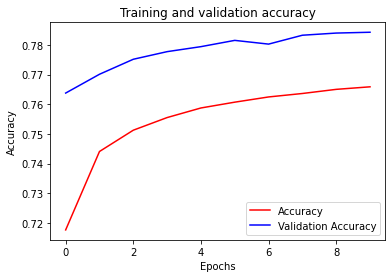

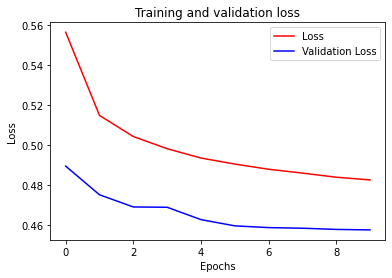

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

#### Pipeline complète d'utilisation du RNN

In [271]:
from tensorflow import keras
trained_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False), # Couche d'entrée chargée avec les poids de GLoVe
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(units=64, return_sequences=True)),
        tf.keras.layers.Bidirectional(LSTM(units=128)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
trained_model.load_weights('/content/drive/MyDrive/Twitter_Dataset/model.h5')
rnn_tokenizer = load('/content/drive/MyDrive/Twitter_Dataset/RNNTokenizer.joblib')

In [290]:
max_length = 20        # Taille maximale d'un tweet
trunc_type='post'      # Tronque le tweet s'il est plus long que max_length
padding_type='post'

def rnn_lstm_pipeline_from_tweets(subject :str):
  raw_tweet = get_random_tweet(subject)
  print("Raw Tweet : " + raw_tweet)
  cleaned_tweet = prepare_string(raw_tweet)
  print("Processed Tweet : " + cleaned_tweet)
  word_vector = rnn_tokenizer.texts_to_sequences([cleaned_tweet])
  word_vector = pad_sequences([word_vector], maxlen=max_length, padding=padding_type, truncating=trunc_type)
  return bool(trained_model.predict(word_vector.reshape(1,-1))[0][0])

def rnn_lstm_pipeline_from_yelp():
  raw_review = get_random_review()
  print("Raw Review : " + raw_review)
  cleaned_review = prepare_string(raw_review)
  print("Processed Review : " + cleaned_review)
  word_vector = rnn_tokenizer.texts_to_sequences([cleaned_review])
  word_vector = pad_sequences([word_vector], maxlen=max_length, padding=padding_type, truncating=trunc_type)

  return bool(trained_model.predict(word_vector.reshape(1,-1))[0][0])



In [291]:
rnn_lstm_pipeline_from_yelp()

Raw Review : I love buying books here! One of my favorite things about this store is that sometimes you can find copies of books signed by the author.
Processed Review : love buying books one favorite things store sometimes find copies books signed author


True

In [292]:
rnn_lstm_pipeline_from_tweets("bookstore")

Raw Tweet : RT @CentristStacy: White liberals going to the bookstore to pick up Robin DiAngelo's latest https://t.co/f0VZJqlR4d
Processed Tweet : white liberals going bookstore pick robin diangelos latest


True

## Conclusion

On observe que les deux modèles d'analyse de sentiment fonctionnent comme prévu, avec des niveaux de précision comparables. La précision des deux modèles pourrait être améliorée grâce à des temps d'entraînement plus long sur des jeux de données adaptés à l'utilisation voulue.